In [1]:
import os,sys
sys.path.append('./PTS')

import numpy as np
from run_skirt import get_lightcurve
from astropy import units as u
from astropy import constants as c
from scipy import optimize as opt
import datetime
import matplotlib.pyplot as plt
from utils import *
%matplotlib inline

18/10/2023 14:06:16.388 ! /usr/lib64/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
18/10/2023 14:06:16.388 !   return _methods._mean(a, axis=axis, dtype=dtype,
18/10/2023 14:06:16.389 ! /usr/lib64/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
18/10/2023 14:06:16.389 !   ret = ret.dtype.type(ret / rcount)
18/10/2023 14:06:16.390 ! /usr/lib64/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
18/10/2023 14:06:16.390 !   ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
18/10/2023 14:06:16.392 ! /usr/lib64/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
18/10/2023 14:06:16.392 !   arrmean = um.true_divide(arrmean, div, out=arrmean,
18/10/2023 14:06:16.392 ! /usr/lib64/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered 

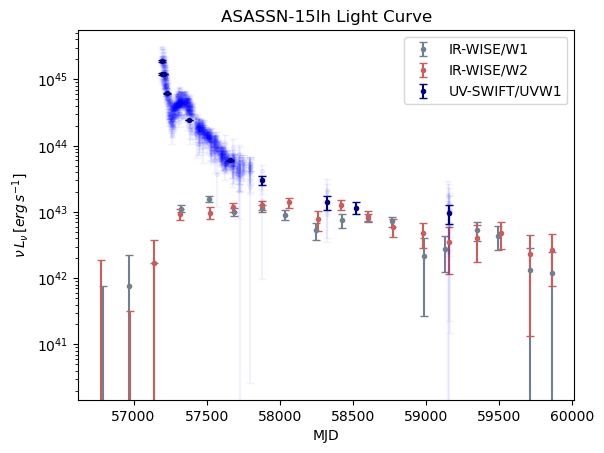

FWHM 41.38972293902923


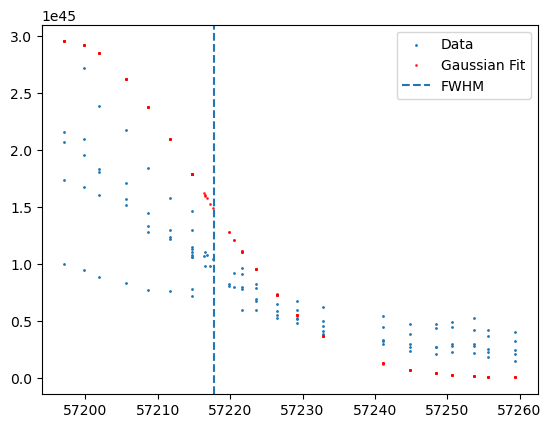

In [2]:
# Define Target and Folders

target = 'ASASSN-15lh'
distance = 1171*u.Mpc
peak = 57250
lightcurve = True

today = str(datetime.date.today()+datetime.timedelta(days=3))
DATAFILES = "data/"+target+'/'
OUTFILES = "results/"+target+'/'+today+'/'
PLOTFILES = "plots/"+target+'/'+today+'/'
if os.path.isdir(DATAFILES) == False:
    os.makedirs(DATAFILES[:-1])
if os.path.isdir(OUTFILES) == False:
    os.makedirs(OUTFILES[:-1])
if os.path.isdir(PLOTFILES) == False:
    os.makedirs(PLOTFILES[:-1])
log=open(OUTFILES+'log.txt','a')

# Define Simulation Parameters
timesteps = 10         # amount of timesteps considered by SKIRT
output_tsteps = 100    # desired amount of timesteps after interpolation
amin = 1e-4            # smallest dust grain size in micron, this is the lowest value supported by SKIRT
grainpowerlaw = 3      # the powerlaw distribution of mass along different grain sizes
alpha = 1              # radial dust mass density powerlaw
total_mass = 10         # of the dust in MSun
Si = 0.                # silicates fraction (as opposed to graphites)
Lbol_factor = 0.1 #0.01       # bolometric correction factor
centralBin = 0.01      # size of central grid section in pc
outer = 5              # outer radius of the dust shell in pc
spaceBins = 100        # number of spatial shells in the radial direction

a_max = [0.01,0.1,1]    # largest dust grain size in micron, now a list to itterative over

# Load the TDE lightcurve
L=np.genfromtxt(DATAFILES+target+'_lc_neutral.dat',skip_header=1).T[0:3]
W1=np.genfromtxt(DATAFILES+target+'_WISEproc.txt',skip_header=1)[:3]
W2=np.genfromtxt(DATAFILES+target+'_WISEproc.txt',skip_header=1)[3:]

# Central wavelength for the 2 WISE filters
wl_w1=3.368*u.um
wl_w2=4.618*u.um

# Reduce the amount of timesteps to 'timesteps', with a number of them concenrated close to the peak
# if timesteps is increased, users might want to omit this
t_data=np.concatenate(([np.min(L[0]),np.sort(L[0])[1],np.sort(L[0])[2],np.min(L[0])+20],\
                       np.linspace(np.min(L[0])+40,np.max(L[0]),timesteps-3)))
L_data=binning(t_data,L[0],L[1],L[2])
t_data=L_data[0]

# We will use a constant temperature of 2e4 K here, 
# as our data set does not provide a very accurate read on the TDE's temperature evolution
T_data = np.array((L_data[0],[2e4]*len(L_data[2])))
output_t=np.linspace(np.min(t_data),np.max(np.concatenate([W1[0],W2[0]])),output_tsteps)

# Plotting the input data
if lightcurve:
    plt.figure()
    plt.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=np.abs((c.c/wl_w1).to(u.Hz).value*W1[2]),\
                 fmt='.',capsize=3,color='slategrey',label='IR-WISE/W1')
    plt.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=np.abs((c.c/wl_w2).to(u.Hz).value*W2[2]),\
                 fmt='.',capsize=3,color='indianred',label='IR-WISE/W2')
    plt.errorbar(L[0],L[1],yerr=L[2],fmt='.',alpha=0.05,capsize=3,color='blue')
    plt.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
    plt.xlabel('MJD')
    plt.ylabel(r"$\nu\,L_{\nu}\,[erg\,s^{-1}]$")
    plt.title(target+' Light Curve')
    plt.yscale('log')
    plt.legend()
    plt.savefig(OUTFILES+target+'_lightcurve.pdf')
    plt.show()

# This implementation cannot track dust survival time
# Therefore dust sublimation is based on the lightcurve's FWHM
# We find this here by fitting a gaussian
def gauss(x, p): # p[0]==mean, p[1]==stdev
    return 1.0/(p[1]*np.sqrt(2*np.pi))*np.exp(-(x-p[0])**2/(2*p[1]**2))

mask = (L[0]<57260)
N = len(L[0,mask])
X = L[0,mask]
Y = L[1,mask]

p0 = [L[0,np.argmax(L[1,:])],L[0,np.argmin(np.abs(L[1]-0.5*np.max(L[1])))]-L[0,np.argmax(L[1,:])]] # Inital guess is a normal distribution
errfunc = lambda p, x, y: gauss(x, p) - y # Distance to the target function
p1, success = opt.leastsq(errfunc, p0[:], args=(X, Y))
fit_mu, fit_stdev = p1
FWHM = 2*np.sqrt(2*np.log(2))*fit_stdev
print("FWHM", FWHM)

# Plot to verify the fit
plt.figure()
plt.scatter(X,Y,s=1,label='Data')
fit=gauss(X,p1)
plt.scatter(X, np.max(Y)/np.max(fit) * fit,s=1,alpha=0.75, color='r',label='Gaussian Fit')
#plt.axvspan(fit_mu-FWHM/2, fit_mu+FWHM/2, facecolor='g', alpha=0.25,label='FWHM')
plt.axvline(fit_mu+FWHM/2, label='FWHM', linestyle='dashed')
plt.legend()
plt.savefig(OUTFILES+'FWHM.pdf')
plt.show()

SKIRT Runs:   0%|                                                                                                                                                     | 0/10 [00:00<?, ?it/s]

18/10/2023 14:06:17.933   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:06:17.933   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:06:17.934   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/57197/torus.ski'...
18/10/2023 14:06:26.907 - Finished setup in 8.8 s.
18/10/2023 14:06:30.730 - Finished setup output in 3.8 s.
18/10/2023 14:06:34.989 - Finished primary emission iteration 1 in 4.3 s.
18/10/2023 14:06:39.031 - Finished primary emission iteration 2 in 4.0 s.
18/10/2023 14:06:43.324 - Finished primary emission iteration 3 in 4.3 s.
18/10/2023 14:06:47.528 - Finished primary emission iteration 4 in 4.2 s.
18/10/2023 14:06:52.364 - Finished primary emission iteration 5 in 4.8 s.
18/10/2023 14:06:57.707 - Finished primary emission iteration 6 in 5.3 s.
18/10/2023 14:07:02.644 - Finished primary emission iteration 7 in 4.9 s.
18/10/2023 14:07:06.714 - Finished primary em

SKIRT Runs:  10%|██████████████                                                                                                                              | 1/10 [01:55<17:19, 115.46s/it]

18/10/2023 14:08:13.232 - Finished final output in 14.5 s.
18/10/2023 14:08:13.232 - Finished simulation torus using 4 threads and a single process in 115 s (1m 55s).
18/10/2023 14:08:13.249   Available memory: 7.64 GB -- Peak memory usage: 254 MB (3.3%)
18/10/2023 14:08:13.391   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:08:13.391   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:08:13.393   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/57197/torus.ski'...
18/10/2023 14:08:22.170 - Finished setup in 8.6 s.
18/10/2023 14:08:25.970 - Finished setup output in 3.8 s.
18/10/2023 14:08:28.059 - Finished primary emission iteration 1 in 2.1 s.
18/10/2023 14:08:30.127 - Finished primary emission iteration 2 in 2.1 s.
18/10/2023 14:08:32.373 - Finished primary emission in 2.2 s.
18/10/2023 14:08:33.920 - Finished secondary emission iteration 1 in 1.5 s.
18/10/2023 14:08:49.66

SKIRT Runs:  20%|████████████████████████████▏                                                                                                                | 2/10 [02:46<10:21, 77.71s/it]

18/10/2023 14:09:04.514 - Finished final output in 14.9 s.
18/10/2023 14:09:04.514 - Finished simulation torus using 4 threads and a single process in 50.9 s.
18/10/2023 14:09:04.537   Available memory: 7.64 GB -- Peak memory usage: 254 MB (3.3%)
18/10/2023 14:09:04.670   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:09:04.670   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:09:04.671   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/57208/torus.ski'...
18/10/2023 14:09:13.478 - Finished setup in 8.7 s.
18/10/2023 14:09:17.290 - Finished setup output in 3.8 s.
18/10/2023 14:09:19.339 - Finished primary emission iteration 1 in 2.0 s.
18/10/2023 14:09:21.409 - Finished primary emission iteration 2 in 2.1 s.
18/10/2023 14:09:23.637 - Finished primary emission in 2.2 s.
18/10/2023 14:09:25.187 - Finished secondary emission iteration 1 in 1.6 s.
18/10/2023 14:09:41.004 - Fini

SKIRT Runs:  30%|██████████████████████████████████████████▎                                                                                                  | 3/10 [03:37<07:38, 65.48s/it]

18/10/2023 14:09:55.450 - Finished final output in 14.4 s.
18/10/2023 14:09:55.450 - Finished simulation torus using 4 threads and a single process in 50.7 s.
18/10/2023 14:09:55.466   Available memory: 7.64 GB -- Peak memory usage: 255 MB (3.3%)
18/10/2023 14:09:55.595   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:09:55.595   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:09:55.596   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/57225/torus.ski'...
18/10/2023 14:10:04.421 - Finished setup in 8.6 s.
18/10/2023 14:10:08.303 - Finished setup output in 3.9 s.
18/10/2023 14:10:10.417 - Finished primary emission iteration 1 in 2.1 s.
18/10/2023 14:10:12.591 - Finished primary emission iteration 2 in 2.2 s.
18/10/2023 14:10:14.783 - Finished primary emission in 2.2 s.
18/10/2023 14:10:16.438 - Finished secondary emission iteration 1 in 1.7 s.
18/10/2023 14:10:33.862 - Fini

SKIRT Runs:  40%|████████████████████████████████████████████████████████▍                                                                                    | 4/10 [04:30<06:03, 60.53s/it]

18/10/2023 14:10:48.395 - Finished final output in 14.5 s.
18/10/2023 14:10:48.395 - Finished simulation torus using 4 threads and a single process in 52.6 s.
18/10/2023 14:10:48.412   Available memory: 7.64 GB -- Peak memory usage: 255 MB (3.3%)
18/10/2023 14:10:48.540   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:10:48.540   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:10:48.541   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/57378/torus.ski'...
18/10/2023 14:10:57.308 - Finished setup in 8.7 s.
18/10/2023 14:11:01.114 - Finished setup output in 3.8 s.
18/10/2023 14:11:03.324 - Finished primary emission iteration 1 in 2.2 s.
18/10/2023 14:11:05.569 - Finished primary emission in 2.2 s.
18/10/2023 14:11:07.307 - Finished secondary emission iteration 1 in 1.7 s.
18/10/2023 14:11:24.226 - Finished secondary emission in 16.9 s.
18/10/2023 14:11:24.226 - Finished the 

SKIRT Runs:  50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 5/10 [05:21<04:45, 57.18s/it]

18/10/2023 14:11:39.633 - Finished final output in 15.4 s.
18/10/2023 14:11:39.633 - Finished simulation torus using 4 threads and a single process in 51.0 s.
18/10/2023 14:11:39.650   Available memory: 7.64 GB -- Peak memory usage: 254 MB (3.3%)
18/10/2023 14:11:39.783   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:11:39.783   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:11:39.784   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/57659/torus.ski'...
18/10/2023 14:11:48.589 - Finished setup in 8.6 s.
18/10/2023 14:11:53.607 - Finished setup output in 5.0 s.
18/10/2023 14:11:55.801 - Finished primary emission iteration 1 in 2.2 s.
18/10/2023 14:11:57.985 - Finished primary emission in 2.2 s.
18/10/2023 14:11:59.689 - Finished secondary emission iteration 1 in 1.7 s.
18/10/2023 14:12:17.463 - Finished secondary emission in 17.8 s.
18/10/2023 14:12:17.463 - Finished the 

SKIRT Runs:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 6/10 [06:14<03:42, 55.50s/it]

18/10/2023 14:12:31.883 - Finished final output in 14.4 s.
18/10/2023 14:12:31.883 - Finished simulation torus using 4 threads and a single process in 51.9 s.
18/10/2023 14:12:31.900   Available memory: 7.64 GB -- Peak memory usage: 254 MB (3.3%)
18/10/2023 14:12:32.029   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:12:32.029   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:12:32.030   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/57881/torus.ski'...
18/10/2023 14:12:40.818 - Finished setup in 8.7 s.
18/10/2023 14:12:45.268 - Finished setup output in 4.4 s.
18/10/2023 14:12:47.410 - Finished primary emission iteration 1 in 2.1 s.
18/10/2023 14:12:49.622 - Finished primary emission in 2.2 s.
18/10/2023 14:12:51.320 - Finished secondary emission iteration 1 in 1.7 s.
18/10/2023 14:13:08.812 - Finished secondary emission in 17.5 s.
18/10/2023 14:13:08.812 - Finished the 

SKIRT Runs:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7/10 [07:05<02:42, 54.30s/it]

18/10/2023 14:13:23.716 - Finished final output in 14.9 s.
18/10/2023 14:13:23.716 - Finished simulation torus using 4 threads and a single process in 51.6 s.
18/10/2023 14:13:23.733   Available memory: 7.64 GB -- Peak memory usage: 254 MB (3.3%)
18/10/2023 14:13:23.866   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:13:23.866   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:13:23.867   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/58324/torus.ski'...
18/10/2023 14:13:32.696 - Finished setup in 8.7 s.
18/10/2023 14:13:37.342 - Finished setup output in 4.6 s.
18/10/2023 14:13:39.378 - Finished primary emission iteration 1 in 2.0 s.
18/10/2023 14:13:41.672 - Finished primary emission in 2.3 s.
18/10/2023 14:13:43.374 - Finished secondary emission iteration 1 in 1.7 s.
18/10/2023 14:14:00.885 - Finished secondary emission in 17.5 s.
18/10/2023 14:14:00.885 - Finished the 

SKIRT Runs:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8/10 [07:57<01:47, 53.53s/it]

18/10/2023 14:14:15.602 - Finished final output in 14.7 s.
18/10/2023 14:14:15.602 - Finished simulation torus using 4 threads and a single process in 51.6 s.
18/10/2023 14:14:15.619   Available memory: 7.64 GB -- Peak memory usage: 253 MB (3.2%)
18/10/2023 14:14:15.744   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:14:15.744   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:14:15.745   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/58519/torus.ski'...
18/10/2023 14:14:24.559 - Finished setup in 8.7 s.
18/10/2023 14:14:29.012 - Finished setup output in 4.5 s.
18/10/2023 14:14:31.116 - Finished primary emission iteration 1 in 2.1 s.
18/10/2023 14:14:33.362 - Finished primary emission in 2.2 s.
18/10/2023 14:14:35.099 - Finished secondary emission iteration 1 in 1.7 s.
18/10/2023 14:14:52.243 - Finished secondary emission in 17.1 s.
18/10/2023 14:14:52.243 - Finished the 

SKIRT Runs:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 9/10 [08:49<00:52, 52.94s/it]

18/10/2023 14:15:07.242 - Finished final output in 15.0 s.
18/10/2023 14:15:07.242 - Finished simulation torus using 4 threads and a single process in 51.4 s.
18/10/2023 14:15:07.258   Available memory: 7.64 GB -- Peak memory usage: 253 MB (3.2%)
18/10/2023 14:15:07.386   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:15:07.386   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:15:07.387   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/59155/torus.ski'...
18/10/2023 14:15:16.327 - Finished setup in 8.7 s.
18/10/2023 14:15:20.135 - Finished setup output in 3.8 s.
18/10/2023 14:15:22.326 - Finished primary emission iteration 1 in 2.2 s.
18/10/2023 14:15:24.596 - Finished primary emission in 2.3 s.
18/10/2023 14:15:26.293 - Finished secondary emission iteration 1 in 1.7 s.
18/10/2023 14:15:43.367 - Finished secondary emission in 17.1 s.
18/10/2023 14:15:43.367 - Finished the 

SKIRT Runs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [09:40<00:00, 58.07s/it]


18/10/2023 14:15:58.458 - Finished final output in 15.1 s.
18/10/2023 14:15:58.458 - Finished simulation torus using 4 threads and a single process in 50.9 s.
18/10/2023 14:15:58.475   Available memory: 7.64 GB -- Peak memory usage: 254 MB (3.3%)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.80it/s]


Compile Lightcurve:   0%|                                                                                                                                            | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   9%|███████████▉                                                                                                                        | 9/100 [00:00<00:01, 78.34it/s]

Compile Lightcurve:  17%|██████████████████████▎                                                                                                            | 17/100 [00:00<00:02, 36.24it/s]

Compile Lightcurve:  22%|████████████████████████████▊                                                                                                      | 22/100 [00:00<00:03, 25.58it/s]

Compile Lightcurve:  26%|███████████████████

Compile Lightcurve:  71%|█████████████████████████████████████████████████████████████████████████████████████████████                                      | 71/100 [00:08<00:06,  4.55it/s]

Compile Lightcurve:  72%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 72/100 [00:08<00:06,  4.50it/s]

Compile Lightcurve:  73%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 73/100 [00:08<00:06,  4.48it/s]

Compile Lightcurve:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 74/100 [00:08<00:05,  4.40it/s]

Compile Lightcurve:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 75/100 [00:09<00:05,  4.33it/s]

Compile Lightcurve:  76%|████████████████████

18/10/2023 14:16:16.095   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:16:16.095   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:16:16.096   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/57197/torus.ski'...
18/10/2023 14:16:24.526 - Finished setup in 8.2 s.
18/10/2023 14:16:28.429 - Finished setup output in 3.9 s.
18/10/2023 14:16:32.766 - Finished primary emission iteration 1 in 4.3 s.
18/10/2023 14:16:36.849 - Finished primary emission iteration 2 in 4.1 s.
18/10/2023 14:16:41.247 - Finished primary emission iteration 3 in 4.4 s.
18/10/2023 14:16:45.266 - Finished primary emission iteration 4 in 4.0 s.
18/10/2023 14:16:49.606 - Finished primary emission iteration 5 in 4.3 s.
18/10/2023 14:16:53.725 - Finished primary emission iteration 6 in 4.1 s.
18/10/2023 14:16:57.688 - Finished primary emission iteration 7 in 4.0 s.
18/10/2023 14:17:01.730 - Finished primary em

SKIRT Runs:  10%|██████████████                                                                                                                              | 1/10 [01:58<17:45, 118.40s/it]

18/10/2023 14:18:14.344 - Finished final output in 14.6 s.
18/10/2023 14:18:14.344 - Finished simulation torus using 4 threads and a single process in 118 s (1m 58s).
18/10/2023 14:18:14.358   Available memory: 7.64 GB -- Peak memory usage: 211 MB (2.7%)
18/10/2023 14:18:14.503   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:18:14.503   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:18:14.504   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/57197/torus.ski'...
18/10/2023 14:18:23.034 - Finished setup in 8.3 s.
18/10/2023 14:18:26.865 - Finished setup output in 3.8 s.
18/10/2023 14:18:28.876 - Finished primary emission iteration 1 in 2.0 s.
18/10/2023 14:18:30.884 - Finished primary emission iteration 2 in 2.0 s.
18/10/2023 14:18:32.880 - Finished primary emission iteration 3 in 2.0 s.
18/10/2023 14:18:35.131 - Finished primary emission in 2.2 s.
18/10/2023 14:18:36.795 

SKIRT Runs:  20%|████████████████████████████▏                                                                                                                | 2/10 [02:52<10:44, 80.61s/it]

18/10/2023 14:19:08.503 - Finished final output in 14.5 s.
18/10/2023 14:19:08.503 - Finished simulation torus using 4 threads and a single process in 53.8 s.
18/10/2023 14:19:08.516   Available memory: 7.64 GB -- Peak memory usage: 214 MB (2.7%)
18/10/2023 14:19:08.644   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:19:08.644   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:19:08.645   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/57208/torus.ski'...
18/10/2023 14:19:16.951 - Finished setup in 8.2 s.
18/10/2023 14:19:20.785 - Finished setup output in 3.8 s.
18/10/2023 14:19:22.907 - Finished primary emission iteration 1 in 2.1 s.
18/10/2023 14:19:25.367 - Finished primary emission iteration 2 in 2.5 s.
18/10/2023 14:19:27.622 - Finished primary emission in 2.3 s.
18/10/2023 14:19:29.187 - Finished secondary emission iteration 1 in 1.6 s.
18/10/2023 14:19:46.407 - Fini

SKIRT Runs:  30%|██████████████████████████████████████████▎                                                                                                  | 3/10 [03:45<07:54, 67.82s/it]

18/10/2023 14:20:01.093 - Finished final output in 14.7 s.
18/10/2023 14:20:01.093 - Finished simulation torus using 4 threads and a single process in 52.3 s.
18/10/2023 14:20:01.106   Available memory: 7.64 GB -- Peak memory usage: 214 MB (2.7%)
18/10/2023 14:20:01.236   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:20:01.236   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:20:01.238   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/57225/torus.ski'...
18/10/2023 14:20:09.844 - Finished setup in 8.4 s.
18/10/2023 14:20:13.661 - Finished setup output in 3.8 s.
18/10/2023 14:20:16.065 - Finished primary emission iteration 1 in 2.4 s.
18/10/2023 14:20:18.161 - Finished primary emission iteration 2 in 2.1 s.
18/10/2023 14:20:20.280 - Finished primary emission in 2.1 s.
18/10/2023 14:20:21.921 - Finished secondary emission iteration 1 in 1.6 s.
18/10/2023 14:20:40.124 - Fini

SKIRT Runs:  40%|████████████████████████████████████████████████████████▍                                                                                    | 4/10 [04:38<06:12, 62.15s/it]

18/10/2023 14:20:54.548 - Finished final output in 14.4 s.
18/10/2023 14:20:54.548 - Finished simulation torus using 4 threads and a single process in 53.1 s.
18/10/2023 14:20:54.561   Available memory: 7.64 GB -- Peak memory usage: 214 MB (2.7%)
18/10/2023 14:20:54.691   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:20:54.691   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:20:54.693   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/57378/torus.ski'...
18/10/2023 14:21:02.970 - Finished setup in 8.2 s.
18/10/2023 14:21:06.834 - Finished setup output in 3.9 s.
18/10/2023 14:21:08.864 - Finished primary emission iteration 1 in 2.0 s.
18/10/2023 14:21:11.246 - Finished primary emission in 2.4 s.
18/10/2023 14:21:12.857 - Finished secondary emission iteration 1 in 1.6 s.
18/10/2023 14:21:30.965 - Finished secondary emission in 18.1 s.
18/10/2023 14:21:30.965 - Finished the 

SKIRT Runs:  50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 5/10 [05:29<04:50, 58.18s/it]

18/10/2023 14:21:45.698 - Finished final output in 14.7 s.
18/10/2023 14:21:45.698 - Finished simulation torus using 4 threads and a single process in 50.9 s.
18/10/2023 14:21:45.712   Available memory: 7.64 GB -- Peak memory usage: 214 MB (2.7%)
18/10/2023 14:21:45.842   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:21:45.842   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:21:45.844   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/57659/torus.ski'...
18/10/2023 14:21:54.326 - Finished setup in 8.3 s.
18/10/2023 14:21:58.226 - Finished setup output in 3.9 s.
18/10/2023 14:22:00.419 - Finished primary emission iteration 1 in 2.2 s.
18/10/2023 14:22:02.741 - Finished primary emission in 2.3 s.
18/10/2023 14:22:04.353 - Finished secondary emission iteration 1 in 1.6 s.
18/10/2023 14:22:22.629 - Finished secondary emission in 18.3 s.
18/10/2023 14:22:22.629 - Finished the 

SKIRT Runs:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 6/10 [06:21<03:43, 55.87s/it]

18/10/2023 14:22:37.093 - Finished final output in 14.5 s.
18/10/2023 14:22:37.093 - Finished simulation torus using 4 threads and a single process in 51.1 s.
18/10/2023 14:22:37.106   Available memory: 7.64 GB -- Peak memory usage: 215 MB (2.7%)
18/10/2023 14:22:37.241   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:22:37.241   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:22:37.242   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/57881/torus.ski'...
18/10/2023 14:22:45.849 - Finished setup in 8.5 s.
18/10/2023 14:22:49.884 - Finished setup output in 4.0 s.
18/10/2023 14:22:51.859 - Finished primary emission iteration 1 in 2.0 s.
18/10/2023 14:22:54.025 - Finished primary emission in 2.2 s.
18/10/2023 14:22:55.664 - Finished secondary emission iteration 1 in 1.6 s.
18/10/2023 14:23:13.672 - Finished secondary emission in 18.0 s.
18/10/2023 14:23:13.672 - Finished the 

SKIRT Runs:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7/10 [07:12<02:43, 54.39s/it]

18/10/2023 14:23:28.422 - Finished final output in 14.7 s.
18/10/2023 14:23:28.422 - Finished simulation torus using 4 threads and a single process in 51.1 s.
18/10/2023 14:23:28.435   Available memory: 7.64 GB -- Peak memory usage: 215 MB (2.7%)
18/10/2023 14:23:28.698   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:23:28.698   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:23:28.703   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/58324/torus.ski'...
18/10/2023 14:23:37.578 - Finished setup in 8.3 s.
18/10/2023 14:23:41.417 - Finished setup output in 3.8 s.
18/10/2023 14:23:43.524 - Finished primary emission iteration 1 in 2.1 s.
18/10/2023 14:23:45.598 - Finished primary emission in 2.1 s.
18/10/2023 14:23:47.270 - Finished secondary emission iteration 1 in 1.7 s.
18/10/2023 14:24:05.119 - Finished secondary emission in 17.8 s.
18/10/2023 14:24:05.119 - Finished the 

SKIRT Runs:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8/10 [08:04<01:47, 53.51s/it]

18/10/2023 14:24:20.068 - Finished final output in 14.9 s.
18/10/2023 14:24:20.068 - Finished simulation torus using 4 threads and a single process in 50.8 s.
18/10/2023 14:24:20.081   Available memory: 7.64 GB -- Peak memory usage: 215 MB (2.8%)
18/10/2023 14:24:20.226   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:24:20.226   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:24:20.232   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/58519/torus.ski'...
18/10/2023 14:24:28.650 - Finished setup in 8.3 s.
18/10/2023 14:24:33.140 - Finished setup output in 4.5 s.
18/10/2023 14:24:35.159 - Finished primary emission iteration 1 in 2.0 s.
18/10/2023 14:24:37.374 - Finished primary emission in 2.2 s.
18/10/2023 14:24:39.025 - Finished secondary emission iteration 1 in 1.6 s.
18/10/2023 14:24:57.046 - Finished secondary emission in 18.0 s.
18/10/2023 14:24:57.046 - Finished the 

SKIRT Runs:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 9/10 [08:55<00:52, 52.90s/it]

18/10/2023 14:25:11.629 - Finished final output in 14.6 s.
18/10/2023 14:25:11.629 - Finished simulation torus using 4 threads and a single process in 51.3 s.
18/10/2023 14:25:11.643   Available memory: 7.64 GB -- Peak memory usage: 215 MB (2.8%)
18/10/2023 14:25:11.775   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:25:11.775   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:25:11.776   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/59155/torus.ski'...
18/10/2023 14:25:20.221 - Finished setup in 8.3 s.
18/10/2023 14:25:24.271 - Finished setup output in 4.0 s.
18/10/2023 14:25:26.350 - Finished primary emission iteration 1 in 2.1 s.
18/10/2023 14:25:28.552 - Finished primary emission in 2.2 s.
18/10/2023 14:25:30.170 - Finished secondary emission iteration 1 in 1.6 s.
18/10/2023 14:25:48.179 - Finished secondary emission in 18.0 s.
18/10/2023 14:25:48.179 - Finished the 

SKIRT Runs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [09:46<00:00, 58.67s/it]


18/10/2023 14:26:02.647 - Finished final output in 14.5 s.
18/10/2023 14:26:02.647 - Finished simulation torus using 4 threads and a single process in 50.7 s.
18/10/2023 14:26:02.661   Available memory: 7.64 GB -- Peak memory usage: 216 MB (2.8%)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.64it/s]


Compile Lightcurve:   0%|                                                                                                                                            | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   9%|███████████▉                                                                                                                        | 9/100 [00:00<00:01, 71.83it/s]

Compile Lightcurve:  17%|██████████████████████▎                                                                                                            | 17/100 [00:00<00:02, 35.05it/s]

Compile Lightcurve:  22%|████████████████████████████▊                                                                                                      | 22/100 [00:00<00:03, 25.31it/s]

Compile Lightcurve:  26%|███████████████████

Compile Lightcurve:  70%|███████████████████████████████████████████████████████████████████████████████████████████▋                                       | 70/100 [00:07<00:06,  4.72it/s]

Compile Lightcurve:  71%|█████████████████████████████████████████████████████████████████████████████████████████████                                      | 71/100 [00:08<00:06,  4.61it/s]

Compile Lightcurve:  72%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 72/100 [00:08<00:06,  4.60it/s]

Compile Lightcurve:  73%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 73/100 [00:08<00:05,  4.53it/s]

Compile Lightcurve:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 74/100 [00:08<00:05,  4.48it/s]

Compile Lightcurve:  75%|████████████████████

18/10/2023 14:26:20.299   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:26:20.299   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:26:20.300   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/57197/torus.ski'...
18/10/2023 14:26:28.679 - Finished setup in 8.2 s.
18/10/2023 14:26:32.894 - Finished setup output in 4.2 s.
18/10/2023 14:26:36.999 - Finished primary emission iteration 1 in 4.1 s.
18/10/2023 14:26:40.853 - Finished primary emission iteration 2 in 3.9 s.
18/10/2023 14:26:44.976 - Finished primary emission iteration 3 in 4.1 s.
18/10/2023 14:26:48.926 - Finished primary emission iteration 4 in 4.0 s.
18/10/2023 14:26:52.828 - Finished primary emission iteration 5 in 3.9 s.
18/10/2023 14:26:56.940 - Finished primary emission iteration 6 in 4.1 s.
18/10/2023 14:27:01.002 - Finished primary emission iteration 7 in 4.1 s.
18/10/2023 14:27:05.089 - Finished primary em

SKIRT Runs:  10%|██████████████                                                                                                                              | 1/10 [01:56<17:24, 116.10s/it]

18/10/2023 14:28:16.254 - Finished final output in 14.5 s.
18/10/2023 14:28:16.254 - Finished simulation torus using 4 threads and a single process in 116 s (1m 56s).
18/10/2023 14:28:16.266   Available memory: 7.64 GB -- Peak memory usage: 216 MB (2.8%)
18/10/2023 14:28:16.415   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:28:16.415   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:28:16.416   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/57197/torus.ski'...
18/10/2023 14:28:24.634 - Finished setup in 8.0 s.
18/10/2023 14:28:28.511 - Finished setup output in 3.9 s.
18/10/2023 14:28:30.748 - Finished primary emission iteration 1 in 2.2 s.
18/10/2023 14:28:33.185 - Finished primary emission iteration 2 in 2.4 s.
18/10/2023 14:28:35.542 - Finished primary emission in 2.4 s.
18/10/2023 14:28:37.309 - Finished secondary emission iteration 1 in 1.8 s.
18/10/2023 14:28:56.95

SKIRT Runs:  20%|████████████████████████████▏                                                                                                                | 2/10 [02:51<10:42, 80.28s/it]

18/10/2023 14:29:11.465 - Finished final output in 14.5 s.
18/10/2023 14:29:11.465 - Finished simulation torus using 4 threads and a single process in 54.9 s.
18/10/2023 14:29:11.477   Available memory: 7.64 GB -- Peak memory usage: 221 MB (2.8%)
18/10/2023 14:29:11.597   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:29:11.597   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:29:11.598   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/57208/torus.ski'...
18/10/2023 14:29:19.741 - Finished setup in 8.0 s.
18/10/2023 14:29:23.604 - Finished setup output in 3.9 s.
18/10/2023 14:29:25.892 - Finished primary emission iteration 1 in 2.3 s.
18/10/2023 14:29:28.171 - Finished primary emission iteration 2 in 2.3 s.
18/10/2023 14:29:30.535 - Finished primary emission in 2.4 s.
18/10/2023 14:29:32.276 - Finished secondary emission iteration 1 in 1.7 s.
18/10/2023 14:29:51.766 - Fini

SKIRT Runs:  30%|██████████████████████████████████████████▎                                                                                                  | 3/10 [03:46<08:01, 68.81s/it]

18/10/2023 14:30:06.637 - Finished final output in 14.9 s.
18/10/2023 14:30:06.637 - Finished simulation torus using 4 threads and a single process in 54.9 s.
18/10/2023 14:30:06.649   Available memory: 7.64 GB -- Peak memory usage: 222 MB (2.8%)
18/10/2023 14:30:06.773   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:30:06.773   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:30:06.775   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/57225/torus.ski'...
18/10/2023 14:30:15.119 - Finished setup in 8.2 s.
18/10/2023 14:30:18.940 - Finished setup output in 3.8 s.
18/10/2023 14:30:21.149 - Finished primary emission iteration 1 in 2.2 s.
18/10/2023 14:30:23.451 - Finished primary emission iteration 2 in 2.3 s.
18/10/2023 14:30:25.898 - Finished primary emission in 2.4 s.
18/10/2023 14:30:27.759 - Finished secondary emission iteration 1 in 1.9 s.
18/10/2023 14:30:48.040 - Fini

SKIRT Runs:  40%|████████████████████████████████████████████████████████▍                                                                                    | 4/10 [04:42<06:22, 63.70s/it]

18/10/2023 14:31:02.499 - Finished final output in 14.5 s.
18/10/2023 14:31:02.499 - Finished simulation torus using 4 threads and a single process in 55.5 s.
18/10/2023 14:31:02.511   Available memory: 7.64 GB -- Peak memory usage: 222 MB (2.8%)
18/10/2023 14:31:02.632   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:31:02.632   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:31:02.634   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/57378/torus.ski'...
18/10/2023 14:31:10.843 - Finished setup in 8.1 s.
18/10/2023 14:31:14.686 - Finished setup output in 3.8 s.
18/10/2023 14:31:16.972 - Finished primary emission iteration 1 in 2.3 s.
18/10/2023 14:31:19.428 - Finished primary emission in 2.5 s.
18/10/2023 14:31:21.312 - Finished secondary emission iteration 1 in 1.9 s.
18/10/2023 14:31:41.842 - Finished secondary emission in 20.5 s.
18/10/2023 14:31:41.842 - Finished the 

SKIRT Runs:  50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 5/10 [05:36<05:00, 60.12s/it]

18/10/2023 14:31:56.260 - Finished final output in 14.4 s.
18/10/2023 14:31:56.260 - Finished simulation torus using 4 threads and a single process in 53.5 s.
18/10/2023 14:31:56.272   Available memory: 7.64 GB -- Peak memory usage: 222 MB (2.8%)
18/10/2023 14:31:56.396   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:31:56.396   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:31:56.397   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/57659/torus.ski'...
18/10/2023 14:32:04.688 - Finished setup in 8.1 s.
18/10/2023 14:32:08.521 - Finished setup output in 3.8 s.
18/10/2023 14:32:10.811 - Finished primary emission iteration 1 in 2.3 s.
18/10/2023 14:32:13.199 - Finished primary emission in 2.4 s.
18/10/2023 14:32:15.047 - Finished secondary emission iteration 1 in 1.8 s.
18/10/2023 14:32:35.889 - Finished secondary emission in 20.8 s.
18/10/2023 14:32:35.889 - Finished the 

SKIRT Runs:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 6/10 [06:30<03:52, 58.02s/it]

18/10/2023 14:32:50.221 - Finished final output in 14.3 s.
18/10/2023 14:32:50.221 - Finished simulation torus using 4 threads and a single process in 53.6 s.
18/10/2023 14:32:50.233   Available memory: 7.64 GB -- Peak memory usage: 222 MB (2.8%)
18/10/2023 14:32:50.357   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:32:50.357   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:32:50.358   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/57881/torus.ski'...
18/10/2023 14:32:58.451 - Finished setup in 8.0 s.
18/10/2023 14:33:02.317 - Finished setup output in 3.9 s.
18/10/2023 14:33:04.685 - Finished primary emission iteration 1 in 2.4 s.
18/10/2023 14:33:07.135 - Finished primary emission in 2.5 s.
18/10/2023 14:33:09.016 - Finished secondary emission iteration 1 in 1.9 s.
18/10/2023 14:33:29.477 - Finished secondary emission in 20.5 s.
18/10/2023 14:33:29.477 - Finished the 

SKIRT Runs:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7/10 [07:23<02:49, 56.65s/it]

18/10/2023 14:33:44.037 - Finished final output in 14.6 s.
18/10/2023 14:33:44.037 - Finished simulation torus using 4 threads and a single process in 53.6 s.
18/10/2023 14:33:44.049   Available memory: 7.64 GB -- Peak memory usage: 222 MB (2.8%)
18/10/2023 14:33:44.173   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:33:44.173   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:33:44.175   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/58324/torus.ski'...
18/10/2023 14:33:52.354 - Finished setup in 8.0 s.
18/10/2023 14:33:56.256 - Finished setup output in 3.9 s.
18/10/2023 14:33:58.516 - Finished primary emission iteration 1 in 2.3 s.
18/10/2023 14:34:01.018 - Finished primary emission in 2.5 s.
18/10/2023 14:34:02.844 - Finished secondary emission iteration 1 in 1.8 s.
18/10/2023 14:34:23.492 - Finished secondary emission in 20.6 s.
18/10/2023 14:34:23.492 - Finished the 

SKIRT Runs:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8/10 [08:17<01:51, 55.82s/it]

18/10/2023 14:34:38.066 - Finished final output in 14.6 s.
18/10/2023 14:34:38.066 - Finished simulation torus using 4 threads and a single process in 53.7 s.
18/10/2023 14:34:38.078   Available memory: 7.64 GB -- Peak memory usage: 223 MB (2.8%)
18/10/2023 14:34:38.206   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:34:38.206   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:34:38.208   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/58519/torus.ski'...
18/10/2023 14:34:46.353 - Finished setup in 8.0 s.
18/10/2023 14:34:50.230 - Finished setup output in 3.9 s.
18/10/2023 14:34:52.446 - Finished primary emission iteration 1 in 2.2 s.
18/10/2023 14:34:54.900 - Finished primary emission in 2.5 s.
18/10/2023 14:34:56.740 - Finished secondary emission iteration 1 in 1.8 s.
18/10/2023 14:35:17.379 - Finished secondary emission in 20.6 s.
18/10/2023 14:35:17.379 - Finished the 

SKIRT Runs:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 9/10 [09:11<00:55, 55.19s/it]

18/10/2023 14:35:31.878 - Finished final output in 14.5 s.
18/10/2023 14:35:31.878 - Finished simulation torus using 4 threads and a single process in 53.6 s.
18/10/2023 14:35:31.890   Available memory: 7.64 GB -- Peak memory usage: 223 MB (2.8%)
18/10/2023 14:35:32.015   Welcome to SKIRT v9.0 (git ed177ca built on 17/10/2023 at 14:21:55)
18/10/2023 14:35:32.015   Running on student49.strw.leidenuniv.nl for vangaalen
18/10/2023 14:35:32.016   Constructing a simulation from ski file '/net/vdesk/data2/vangaalen/DustEcho/results/ASASSN-15lh/2023-10-21/59155/torus.ski'...
18/10/2023 14:35:40.280 - Finished setup in 8.1 s.
18/10/2023 14:35:44.116 - Finished setup output in 3.8 s.
18/10/2023 14:35:46.409 - Finished primary emission iteration 1 in 2.3 s.
18/10/2023 14:35:48.707 - Finished primary emission in 2.3 s.
18/10/2023 14:35:50.539 - Finished secondary emission iteration 1 in 1.8 s.
18/10/2023 14:36:11.555 - Finished secondary emission in 21.0 s.
18/10/2023 14:36:11.555 - Finished the 

SKIRT Runs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:06<00:00, 60.67s/it]


18/10/2023 14:36:26.817 - Finished final output in 15.3 s.
18/10/2023 14:36:26.817 - Finished simulation torus using 4 threads and a single process in 54.6 s.
18/10/2023 14:36:26.829   Available memory: 7.64 GB -- Peak memory usage: 223 MB (2.9%)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.13it/s]


Compile Lightcurve:   0%|                                                                                                                                            | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   9%|███████████▉                                                                                                                        | 9/100 [00:00<00:01, 74.95it/s]

Compile Lightcurve:  17%|██████████████████████▎                                                                                                            | 17/100 [00:00<00:02, 35.77it/s]

Compile Lightcurve:  22%|████████████████████████████▊                                                                                                      | 22/100 [00:00<00:02, 26.11it/s]

Compile Lightcurve:  26%|███████████████████

Compile Lightcurve:  71%|█████████████████████████████████████████████████████████████████████████████████████████████                                      | 71/100 [00:08<00:06,  4.52it/s]

Compile Lightcurve:  72%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 72/100 [00:08<00:06,  4.52it/s]

Compile Lightcurve:  73%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 73/100 [00:08<00:06,  4.43it/s]

Compile Lightcurve:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 74/100 [00:08<00:05,  4.41it/s]

Compile Lightcurve:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 75/100 [00:08<00:05,  4.34it/s]

Compile Lightcurve:  76%|████████████████████

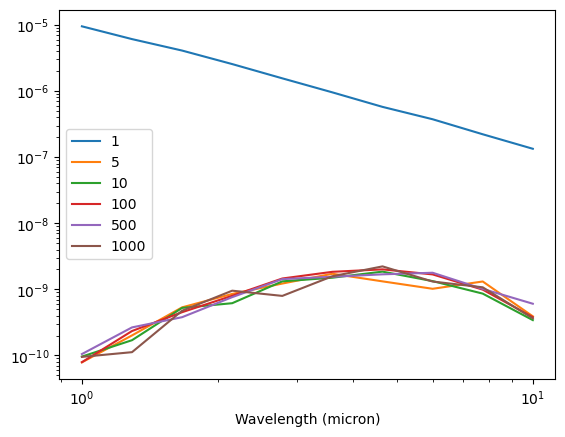

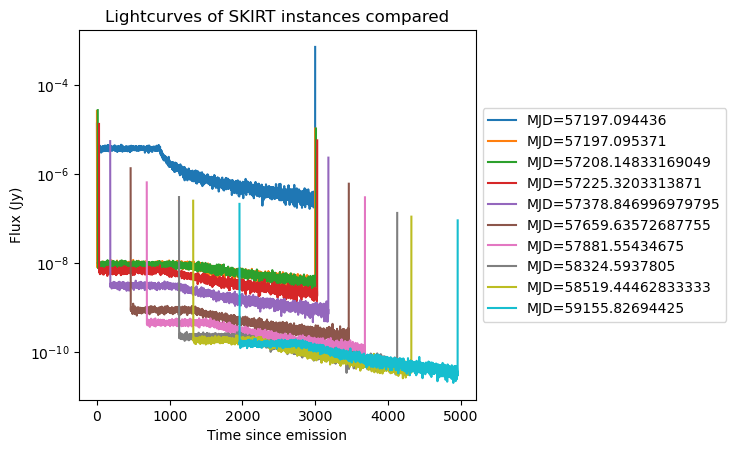

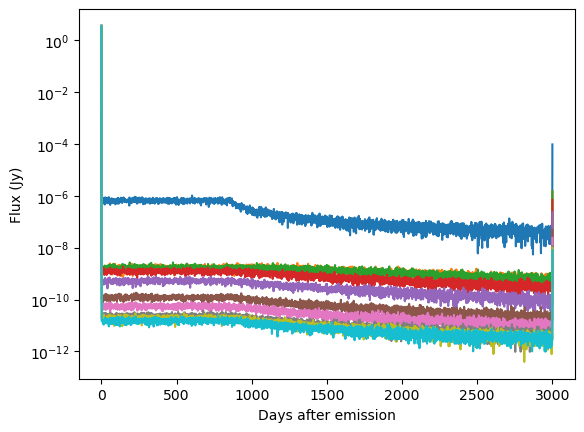

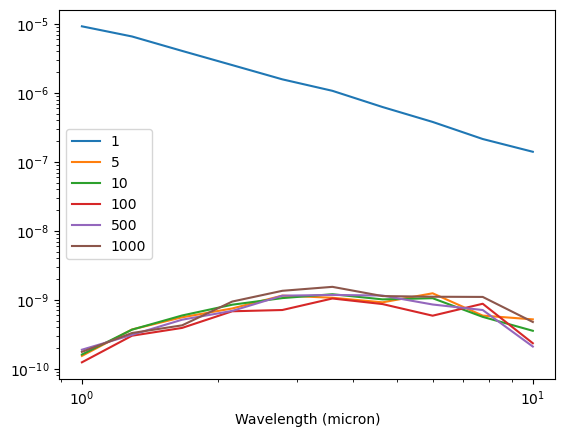

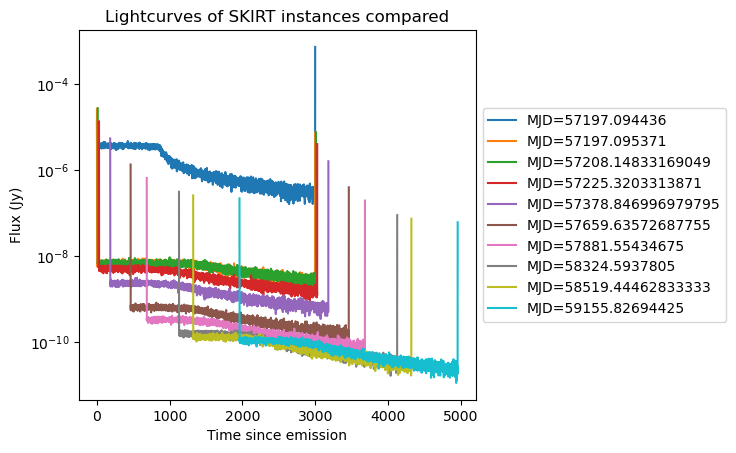

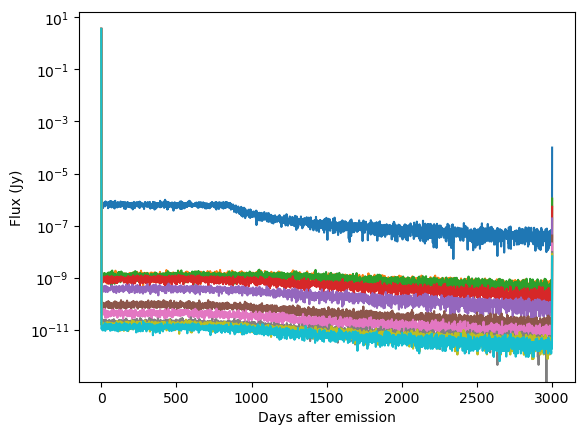

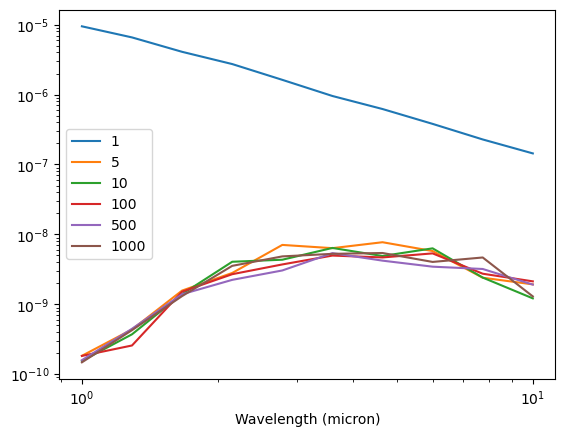

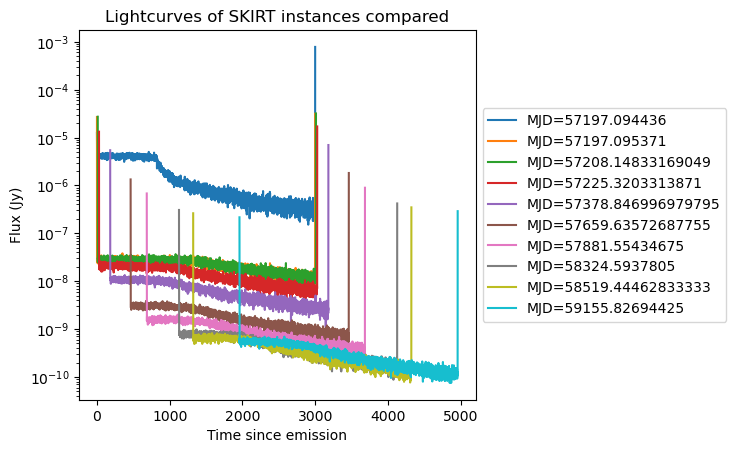

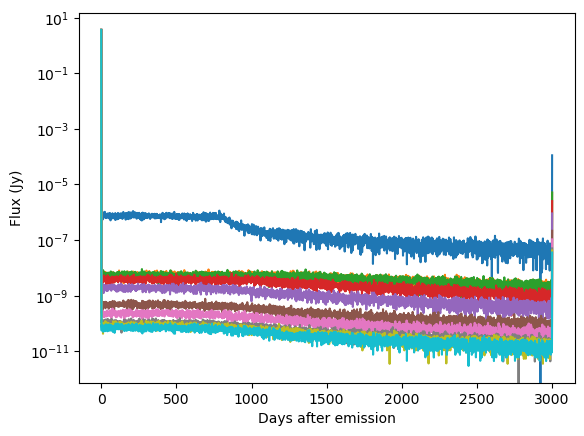

In [3]:
# Start the run
lightcurves = []
for amax in a_max:
    if Si!=False:
        print('x')
        lightcurve,wavelengths,temp,radius = get_lightcurve(np.array((L_data[0],L_data[1]*Lbol_factor\
                                                                    ,L_data[2]*Lbol_factor))\
                                                        ,T_data,t_data,output_t,\
                                                        [centralBin,outer,alpha,total_mass],\
                                                        [amin,amax,grainpowerlaw],FWHM,spaceBins,distance=distance,\
                                                        skiname='TDE_C+Si.ski',Si=Si,prefix=str(today),\
                                                        OUTFILES=OUTFILES,plot_SED=True,SKIRTpath='SKIRT10/release/SKIRT/main/skirt')
    else:
        lightcurve,wavelengths,temp,radius = get_lightcurve(np.array((L_data[0],L_data[1]*Lbol_factor \
                                                                    ,L_data[2]*Lbol_factor)) \
                                                        ,T_data,t_data,output_t \
                                                        ,[centralBin,outer,alpha,total_mass] \
                                                        ,[amin,amax,grainpowerlaw],FWHM,spaceBins,distance=distance \
                                                        ,skiname='TDE.ski',Si=Si,prefix=str(today) \
                                                        ,OUTFILES=OUTFILES,plot_SED=True,SKIRTpath='SKIRT10/release/SKIRT/main/skirt')
    lightcurves.append(lightcurve) #we only use the lightcurve and wavelengths arrays here, the temp and radius arrays give the temperature and radius of the inntermost dust layer

In [39]:
unit=lightcurve.unit
print(unit)
# indices corresponding to the WISE filter wavelengths
w1=np.argmin(np.abs(wavelengths-wl_w1.value))
w2=np.argmin(np.abs(wavelengths-wl_w2.value))

# Convert and Save
luminosities=FluxtoLum(np.array(lightcurves)*unit,distance=distance)
maxW1=W1[1]*u.erg/u.s/u.Hz
coveringFactor=np.max(W1[1]*u.erg/u.s/u.Hz)/luminosities[:,np.argmin(np.abs(output_t-W1[0,np.argmax(W1[1])])),w1]
#coveringFactor=1
#print(luminosities)
print(coveringFactor)
log.write('amax='+str(a_max)+', grainpowerlaw='+str(grainpowerlaw)+', coveringFactor='+str(coveringFactor)+', sublimation radius='+str(np.min(radius))+', T_min='+np.array2string(np.array(temp),max_line_width=len(temp)*100))
log.write('\n')
if os.path.isdir(OUTFILES+'GridSearch/')==False:
    os.makedirs(OUTFILES+'GridSearch/')
if os.path.isdir(PLOTFILES+'/')==False:
    os.makedirs(PLOTFILES+'/')

np.savetxt(OUTFILES+'config(0).txt',luminosities[0].value)
np.savetxt(OUTFILES+'config(1).txt',luminosities[1].value)
np.savetxt(OUTFILES+'config(2).txt',luminosities[2].value)

Jy
[302.95612257 365.41474669 115.05905273]


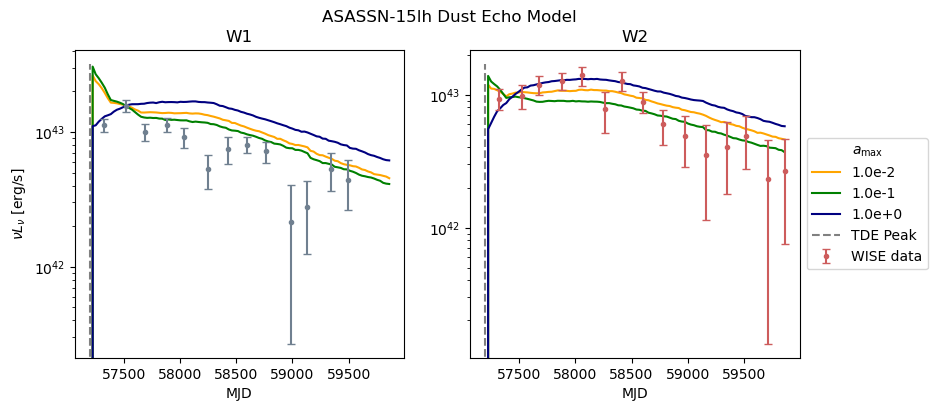

In [91]:
from matplotlib import cm
import matplotlib.colors as mpl_c
import seaborn as sns
fig=plt.figure(figsize=[10, 4])
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

vmin=np.log10(np.min(a_max))
vmax=np.log10(np.max(a_max))
colors = ['orange', 'green', 'navy']
for i,luminosity in enumerate(luminosities):
    ax1.plot(output_t,(c.c/wl_w1).to(u.Hz).value*luminosity[:,w1]*coveringFactor[i] \
             ,label=np.format_float_scientific(a_max[i], unique=False, exp_digits=1,precision=1) \
             ,color=colors[i])
    ax2.plot(output_t,(c.c/wl_w2).to(u.Hz).value*luminosity[:,w2]*coveringFactor[i] \
             ,label=np.format_float_scientific(a_max[i], unique=False, exp_digits=1,precision=1) \
             ,color=colors[i])

maskw1=(W1[1]>W1[2])
maskw2=(W2[1]>W2[2])
ax1.errorbar(W1[0][maskw1],(c.c/wl_w1).to(u.Hz).value*W1[1][maskw1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2][maskw1], \
             fmt='.',capsize=3,label='W1 data',color='slategrey')
ax2.errorbar(W2[0][maskw2],(c.c/wl_w2).to(u.Hz).value*W2[1][maskw2],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2][maskw2], \
             fmt='.',capsize=3,label='WISE data',color='indianred')
ax1.plot([L[0][np.argmax(L[1,:])]]*2,ax1.get_ylim(),linestyle='dashed',color='grey',label='TDE Peak')
ax2.plot([L[0][np.argmax(L[1,:])]]*2,ax2.get_ylim(),linestyle='dashed',color='grey',label='TDE Peak')
ax1.set_yscale('log')
ax2.set_yscale('log')
box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5),title=r'$a_{\mathrm{max}}$')
ax1.set_xlabel('MJD')
ax2.set_xlabel('MJD')
ax1.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax1.set_title('W1')
ax2.set_title('W2')
fig.subplots_adjust(right=0.85)
fig.suptitle(target+' Dust Echo Model')
fig.savefig(PLOTFILES+'compare_amax.pdf')